# Introduction to Policy Gradients

This post will introduce the core concepts underlying various **policy gradient algorithms**. As opposed to previously introduced methods - which suffered of the curse of dimensionality - it is not necessary to analyze the full action space to update the policy $\pi$.
These algorithms are an approach to reinforcement learning utilizing **stochastic gradient ascent**.

## The Goal

Those of you familiar with neural networks will probably have heard of stochastic gradient descent. The goal of stochastic gradient descent is to calculate the gradient of a loss-function to then adjust the parameters of the network to minimize the loss-function by steping in the opposite direction of the gradient.

We can utlize the very similar stochastic gradient ascent to appraoch reinforcment learning problems. To do this, we will need a reward function $J(\theta)$ which tells us how well a given policy $\pi_\theta$ performs using the parameters $\theta$.  In reinforcment learning this is actually quite simple since reinforcment inherintly utilizes rewards $r$. Thus the reward function is chosen to be the exoected reward for a trajectory $\tau$ generated by the current policy $\pi_\theta$. Let $G(\tau)$ be the infinite horizon discounted-return starting at timestep $t = 0$ for the trajectory $\tau$. 

The derivation of the policy gradient using finite or undiscounted return are almost identical. For finite horizon $T$ simply replace all $\infty$ with $T$.

\begin{align}
    G(\tau) &= \sum_{t = 1}^\infty \gamma^t r_{t+1} \\
    J(\theta) &= \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} [ G(\tau) ] \\
\end{align}

If it is possible to now calculate the gradient of the reward function $J(\theta)$ we can take a stochastic gradient ascent step based on a hyperparameter $\alpha$ to slowly over many steps maximise the reward function:

\begin{align}
    \theta = \theta + \alpha \nabla_\theta J(\theta)
\end{align}

The only remaining probelem is to actually determine how the gradient $\nabla_\theta J(\theta)$ looks like.

## How to calculate the Gradient

##### Step 1:

We now that if $X$ is a random variable, $P(x)$ is the probability that $X = x$ and we want to calculate $\mathbb{E}[X]$ we can do this by calculating $\mathbb{E}[X] = \sum_x P(x) x$ and thereby summing over all possible values of $X=x$ multiplied with their respective probability.

We can do something similar for $J(\theta)$ by summing over all posible trajectories $\tau$ if we rely on the probability that $\tau$ occurs given policy $\pi_\theta$ determined by paramteres $\theta$ $P(\tau | \theta)$.

\begin{align}
    J(\theta) &= \sum_\tau P(\tau | \theta) G(\tau) \\
    \nabla_\theta J(\theta) &= \nabla_\theta \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} [ G(\tau) ] \\
    &= \nabla_\theta \sum_\tau P(\tau | \theta) G(\tau) \\
    &= \sum_\tau \nabla_\theta P(\tau | \theta) G(\tau) \\
\end{align}

##### Step 2:

Given a function $f(x)$ the log-derivative trick is useful for rewriting the derivative $\frac{d}{dx} f(x)$ and relies upon the derivative of $\log(x)$ being $\frac{1}{x}$ and the chain rule.

\begin{align}
    \frac{d}{dx} f(x) &= f(x) \frac{1}{f(x)} \frac{d}{dx} f(x) \\
    &= f(x)\frac{d}{dx} \log(f(x)) \\
\end{align}

Since $G(\tau)$ is not dependant on $\theta$ we can apply this trick to $P(\tau | \theta)$:

\begin{align}
    J(\theta) &= \sum_\tau \nabla_\theta P(\tau | \theta) G(\tau) \\
    &= \sum_\tau P(\tau | \theta) \nabla_\theta \log(P(\tau | \theta)) G(\tau) \\
\end{align}

##### Step 3:

An equation for $P(\tau | \theta)$ is still required, but can be found by considering the problem as an markov decision process (MDP). Let $p(s_1)$ be the probability of starting a trajectory in state $s_1$, then $P(\tau | \theta)$ can be expressed by multiplying the probabilities for each occurence of all states $s_t$ and actions $a_t$.

\begin{align}
    P(\tau | \theta) &= p(s_1) \prod_{t = 1}^\infty P(s_{t+1} | s_t, a_t) \pi_\theta(a_t | s_t) \\
    \log(P(\tau | \theta)) &= \log(p(s_1)) \sum_{t = 1}^\infty \big( \log(P(s_{t+1} | s_t, a_t)) + \log(\pi_\theta(a_t | s_t)\big)) \\
\end{align}

##### Step 4

Notice that $p(s_1)$ and $P(s_{t+1} | s_t, a_t)$ are also not dependant on $\theta$. 

\begin{align}
    \nabla_\theta \log(P(\tau | \theta)) &= \sum_{t = 1}^\infty \pi_\theta(a_t | s_t) \\
\end{align}

\begin{align}
    \nabla_\theta J(\theta) &= \sum_\tau P(\tau | \theta) \sum_{t = 1}^\infty \log(\pi_\theta(a_t | s_t)) G(\tau) \\
\end{align}

Now we can reverse step 1 leaving us with finished equation which can be estimated by sampling multiple trajectories and taking the mean of the gradients for the sampled trajcetories.

\begin{align}
    \nabla_\theta J(\theta) &= \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} \left[ \sum_{t = 1}^\infty \log(\pi_\theta(a_t | s_t)) G(\tau) \right] \\
\end{align}

### Baselines

Often when facing reinforcement learning problems, we are dealing with probability distributions like $\pi_\theta(a|s), P(\tau | \theta), P(s_{t+1} | s_t, a_t)$. Since they are defined as probability distibutions these are always normalized. Given a $P_\theta(x)$ this means:

\begin{align}
    1 = \sum_x P_\theta(x)
\end{align}

If we not take the gradient of both sides and use the log-derivative trick we get:

\begin{align}
    \nabla_\theta 1 &= \nabla_\theta \sum_x P_\theta(x) \\
    0 &= \sum_x \nabla_\theta P_\theta(x) \\
    0 &= \sum_x P_\theta(x) \nabla_\theta \log(P_\theta(x)) \\
    0 &= \mathop{\mathbb{E}}_{x \sim P_\theta(x)} \left[ \nabla_\theta \log(P_\theta(x)) \right]\\
\end{align}

This lemma can be used in combination with the rules for the expected value to yield the following, given a state $s_t$ and an arbitrary function $b(s_t)$ only depending on the state:

\begin{align}
    \mathop{\mathbb{E}}_{a_t \sim \pi(a_t | s_t)} \left[ \nabla_\theta \log(\pi(a_t | s_t)) b(s_t) \right] &= \mathop{\mathbb{E}}_{a_t \sim \pi(a_t | s_t)} \left[ \nabla_\theta \log(\pi(a_t | s_t)) \right] \cdot \mathop{\mathbb{E}}_{a_t \sim \pi(a_t | s_t)} [b(s_t)]\\
    &= \mathop{\mathbb{E}}_{a_t \sim \pi(a_t | s_t)} \left[ \nabla_\theta \log(\pi(a_t | s_t)) \right] \cdot b(s_t)\\
    &= 0 \cdot b(s_t)\\
    &= 0 \\
\end{align}

Since the expected value of this expression is $0$ we can freely add or subtract it to the policy gradient equation. In this case the function $b(s_t)$ is called **baseline**. One common baseline is the value function $V^{\pi_{\theta}}(s_t)$ as this reduced the variance when approximating the equation through sampling, thus helping us to dermine the gradient with a higher accuracy.

\begin{align}
    \nabla_\theta J(\theta) &= \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} \left[ \sum_{t = 1}^\infty \log(\pi_\theta(a_t | s_t)) (G(\tau) - b(s_t)) \right] \\
    \nabla_\theta J(\theta) &= \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} \left[ \sum_{t = 1}^\infty \log(\pi_\theta(a_t | s_t)) (G(\tau) - V^{\pi_{\theta}}(s_t)) \right] \\
\end{align}

Though this alteration requires a way to calculate $V^{\pi_{\theta}}(s_t)$. This is most often achieved through a second neural network trained to approximate $V^{\pi_{\theta}}(s_t)$ as best as possible.



## Alternative expressions for policy gradient


The generalized form of policy gradient for finite-horizon and undiscounted return is defined as:
$$\nabla_\theta J(\pi_\theta) = \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} \big[\sum^T_{t=0}\nabla_\theta log \pi_\theta(a_t|s_t)R(\tau) \big]  $$ The sole components of this expression are already defined above in the derivation section albeit for the infinte horizon. However, to observe the alternate forms of this expression we would replace $R_\tau$ with $\Phi_\tau $:
$$ \nabla_\theta J(\pi_\theta) = \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} \big[\sum^T_{t=0}\nabla_\theta log \pi_\theta(a_t|s_t)\Phi_\tau \big] $$ <br>


We can now use $\Phi$ to form alternate approaches for this expression which would yield the same results. For the sake of completeness we note down: $\Phi_\tau = R(\tau)$. Furthermore, $R(\tau)$ can be dissolved into $\sum^T_{t'=t}R(s_{t'},a_{t'},s_{t'+1}).$ The reason behind this is that $R(\tau)$ would mean we observe the sum of all rewards that were obtained however past rewards should not influence the Reinforcement of the action.Consequently, this means it would only be sensible to observe the rewards that come after the action which would be reinforced: $\Phi_\tau = \sum^T_{t'=t}R(s_{t'},a_{t'},s_{t'+1})$.  <br>

The on-policy action value function $ Q^\pi(s,a) = \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} \big[R(\tau)|s_0=s, a_0=a\big]   $, that gives the expected return when starting in a state s and taking an action a  can also be an expression for $\Phi$. This is [proven](https://spinningup.openai.com/en/latest/spinningup/extra_pg_proof2.html) by using the law of iterated expectations and the result would give: $$\nabla_\theta J(\pi_\theta) = \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} \big[\sum^T_{t=0}\nabla_\theta log \pi_\theta(a_t|s_t) Q^{\pi_{\theta}}(s,a) \big] $$ <br>



The Advantage Function $A^\pi = Q^\pi(s,a)- V^\pi(s) $, that is used to calculate the advantage of an action over other actions, is proven in the same way as the action-value function and can also be inserted into the policy gradient expression: $$\nabla_\theta J(\pi_\theta) = \mathop{\mathbb{E}}_{\tau \sim \pi_\theta} \big[\sum^T_{t=0}\nabla_\theta log \pi_\theta(a_t|s_t) A^{\pi_{\theta}}(s_t,a_t) \big] $$
<br>

All of these expressions have one thing in common: it is the __same__ expected value of the policy gradient even though they differ in the form.

## REINFORCE - an exemplary policy gradient algorithm

To get a better understanding of these underlying concepts, we'll introduce REINFORCE - a popular policy gradient algorithm.
The base idea of this algorithm is the estimation of the return using Monte-Carlo methods based on episode samples and utilizing those to update the policy $\pi$.
The following pseudo algorithm shows the generation of a real and full sample trajectories.
The estimated return $G_t$ computed by using these trajectories can then be used to update the policy parameter $\theta$ because of the already introduced equality between the expectation of the sample gradient and the actual gradient. 


### Pseudoalgorithm:

1. Initialize the policy parameter $\theta$ at random.
2. Generate one trajectory on policy $\pi_\theta: S_1, A_1, R_2, S_2, A_2, ..., S_T$
3. For $t=1, 2, ..., T:$
    1. Estimate the return $G_T$;
    2. Update policy parameters: $\theta \leftarrow \theta + \alpha\gamma^t G_t \nabla_\theta ln_{\pi_\theta}\left( A_t | S_t \right)$

### Exemplary implementation

To get a better understanding a code example for OpenAI Gym's CartPole environment is provided.

#### CartPole

The environment consists of a pole that is attached to a cart via a joint. Force can be applied to the cart in both horizontal directions. The goal is to keep the pole upright (less than 15 degrees from vertical) for as long as possible (while the timesteps were limited to 200 max for this training). The agent receives a reward of +1 for every timestep that it keeps the pole from falling over or moving the cart more than 2.4 units from the center.

In [1]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Constants
GAMMA = 0.9

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])
        return highest_prob_action, log_prob

In [2]:
def update_policy(policy_network, rewards, log_probs):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradient.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    policy_gradient = torch.stack(policy_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [3]:
def reinforce(print_trace=True):
    env = gym.make('CartPole-v0')
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)
    
    max_episode_num = 5000
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []

    for episode in range(max_episode_num):
        state = env.reset()
        log_probs = []
        rewards = []

        for steps in range(max_steps):
            env.render()
            action, log_prob = policy_net.get_action(state)
            new_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                update_policy(policy_net, rewards, log_probs)
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                if print_trace and episode % 1 == 0:
                    sys.stdout.write("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
                break
            
            state = new_state
        
    plt.plot(numsteps)
    plt.plot(avg_numsteps)
    plt.xlabel('Episode')
    plt.show()

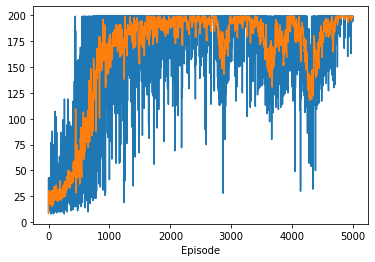

In [4]:
reinforce(print_trace=False)

### Conclusion

Policy gradient is an efficient RL method without the need of analyzing the entire action space - as opposed to previously introduced methods like Q-Learning and thus avoiding the curse of dimensionality.

## References

- [Lilian Wang: Policy Gradient Algorithms](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html)

- [OpenAI: Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#optional-formalism)

- [Chris Yoon: Deriving Policy Gradients and Implementing REINFORCE](https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63)

- [OpenAI Gym Cartpole](https://gym.openai.com/envs/CartPole-v1)
